## Set-up basic HurryWave model

### Modules and packages

Here we import the necessary modules and packages to run the HurryWave model. The HurryWave model is located in the cht_hurrywave module, while other packages such as numpy, matplotlib, and geopandas are imported for numerical computation, visualization, and geographic data manipulation.


In [1]:
import numpy as np
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import xarray as xr
from cht_meteo.meteo import MeteoGrid
import datetime

from cht_hurrywave.hurrywave import HurryWave
from cht_hurrywave.boundary_conditions import HurryWaveBoundaryConditions;


### Initialize model

In this step, we define the model path (model_path) where the HurryWave model resides, and initialize the model using the HurryWave class. The model will be used to simulate wave blocking behavior based on bathymetry and other input data.



In [2]:
model_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\tmp'
hw = HurryWave(path=model_path)

### Domain and Grid

Here, we specify the input domain variables such as the domain's geographical extent (x0, y0), grid resolution (dx, dy), and the grid's maximum extents (mmax, nmax). We then use these specifications to build the model's grid and define the model's exterior boundary.

In [3]:
# Set domain input variables
specs = {'x0': -75, 'y0': 7, 'dx': 0.1, 'dy': 0.1, 
        'mmax': 200, 'nmax': 150, 'rotation': 0.0, 
        'crs_name': 'WGS 84', 'crs_type': 'geographic'}

hw.input.update(specs)
# Build grid
hw.grid.build()

hw.grid.exterior.to_file(os.path.join(hw.path, "gis", "region.geojson"), driver='GeoJSON')


### Bathymetry 

This section focuses on bathymetry, which is the study of underwater topography. Bathymetric data is essential to understand how waves interact with the seafloor and coastal structures.

We load bathymetric data from a GeoTIFF file using the rioxarray package, which helps read raster data efficiently. We then interpolate this bathymetry data to match the grid resolution of the HurryWave model. Afterward, we update the bathymetry data in the model's grid and plot the bathymetric data to visualize it.


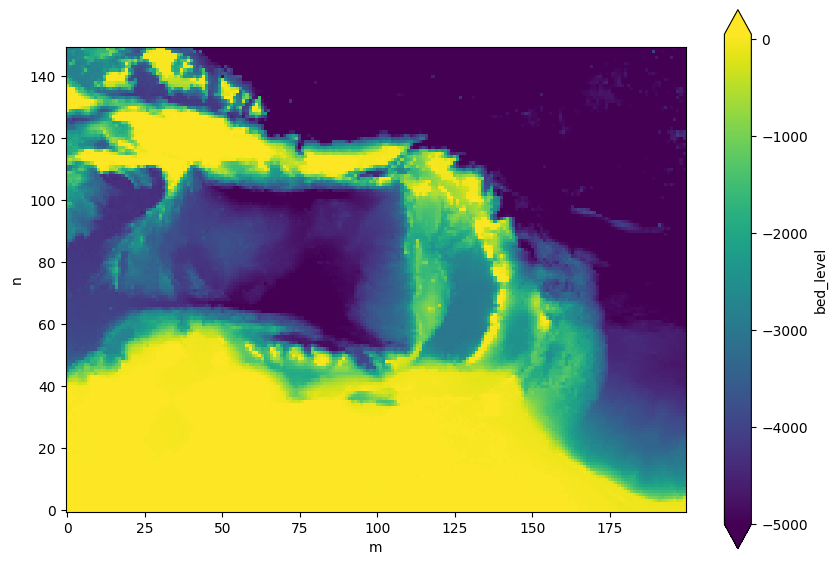

In [4]:
tif_file = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\Bathymetry\gebco_2024_n27.0_s0.0_w-84.0_e-48.0.tif'
data = rioxarray.open_rasterio(tif_file)
dep = data[0].data

# Interpolate to keep data small
x_dep = data.x
y_dep = data.y

xgr_dep, ygr_dep = np.meshgrid(x_dep, y_dep)

hw.input.update({'mskfile': 'hurrywave.msk', 'depfile': 'hurrywave.dep'})

# Get bathy/topo
hw.grid.set_bathymetry_from_other_source2(xgr_dep[0,:], ygr_dep[:,0], dep)


fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds["bed_level"].plot(ax = ax, vmin = -5000, vmax = 50)


### Mask

The "mask" defines which areas of the grid are land and which are water. In this section, we define the boundaries where the model considers the areas for calculations. A mask file is used to represent the boundary (= 2) active (= 1) and inactive (= 0) areas of the grid. This helps filter out the land area when calculating wave propagation in the water regions.

We load any boundary polygons if available and apply a mask based on defined depth values (e.g., zmin and zmax to specify the depth range of interest). Finally, the grid mask is written to a file, and a plot is displayed to visualize the grid with the applied mask.

No name for obs file !


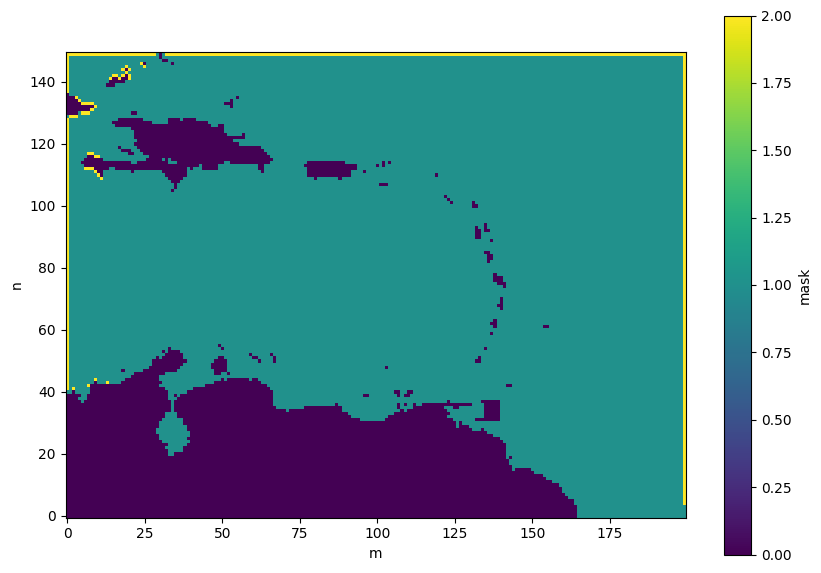

In [5]:
# Initialize polygons as None
include_polygon = None
exclude_polygon = None
boundary_polygon = None

boundary_polygon = gpd.read_file(os.path.join(hw.path, "gis", "open_boundary_polygon.shp"))
hw.grid.build_mask(zmin=-10000,
                    zmax=1,
                    include_polygon=include_polygon,
                    include_zmin=None, include_zmax=None,
                    boundary_polygon = boundary_polygon,
                    boundary_zmax= -100
                    )

                    
hw.grid.write_msk_file()
fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds.mask.plot(ax = ax)
hw.write()

### Boundary conditions

To define boundary conditions, a seperate object (HurryWaveBoundaryConditions) is called. Using get_boundary_from_mask, boundary points are generated on a fixed interval along your open boundary. Next, you can create a uniform timeseries that describe the wave parameters. 

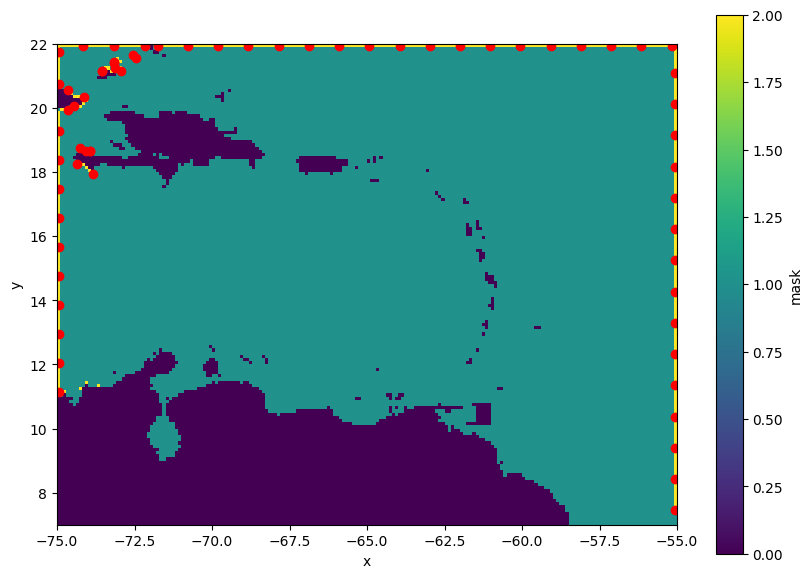

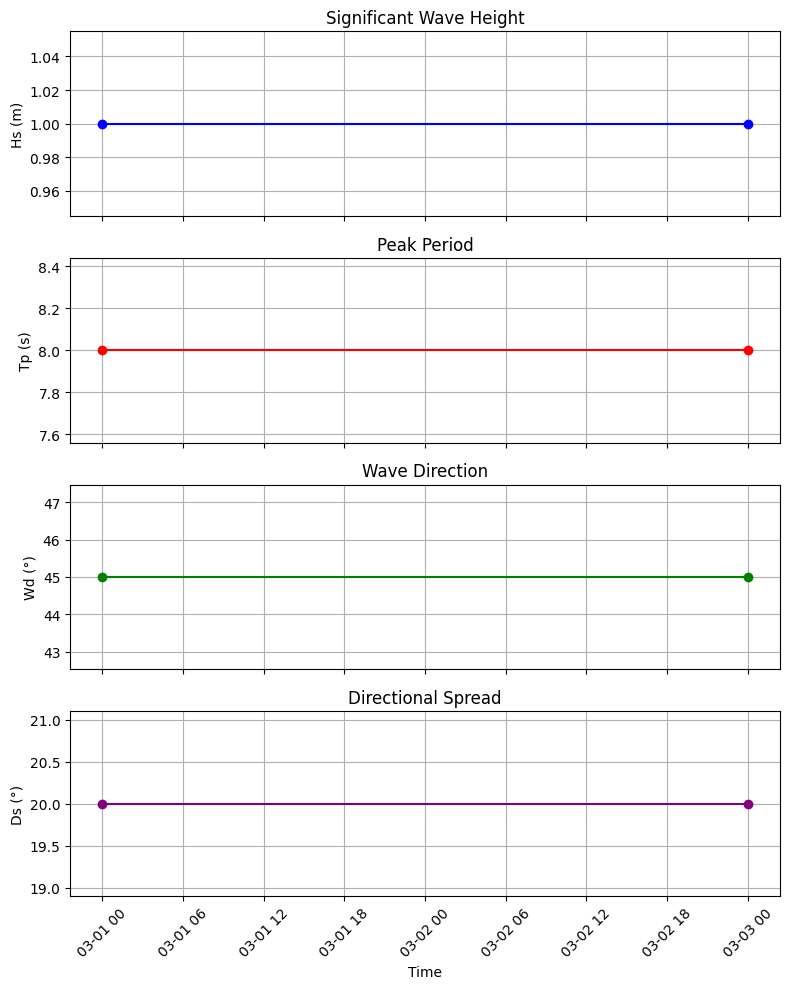

In [6]:
# Create boundary points based on mask

bnd_points = HurryWaveBoundaryConditions(hw = hw)
bnd_points.get_boundary_points_from_mask(bnd_dist=1)
bnd_points.write_boundary_points()

fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.set_aspect("equal")
hw.grid.ds.mask.plot(ax = ax, x = 'x', y = 'y')


bnd_points.gdf.plot(ax = ax, color = "red")

# Set all boundary conditions to constant values
bnd_points.set_timeseries_uniform(hs = 1.0, tp = 8.0, wd = 45.0, ds = 20.0)
bnd_points.write_boundary_conditions_timeseries()

# Plot timeseries

df = bnd_points.gdf.timeseries[0]

# Creating the figure and subplots
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

# Plot each parameter
axes[0].plot(df.index, df["hs"], marker='o', linestyle='-', color='b')
axes[0].set_ylabel("Hs (m)")
axes[0].set_title("Significant Wave Height")
axes[0].grid(True)


axes[1].plot(df.index, df["tp"], marker='o', linestyle='-', color='r')
axes[1].set_ylabel("Tp (s)")
axes[1].set_title("Peak Period")
axes[1].grid(True)

axes[2].plot(df.index, df["wd"], marker='o', linestyle='-', color='g')
axes[2].set_ylabel("Wd (°)")
axes[2].set_title("Wave Direction")
axes[2].grid(True)

axes[3].plot(df.index, df["ds"], marker='o', linestyle='-', color='purple')
axes[3].set_ylabel("Ds (°)")
axes[3].set_title("Directional Spread")
axes[3].set_xlabel("Time")
axes[3].grid(True)

# Formatting
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Uniform wind conditions

Scripts to give HW uniform grid forcing. (**it can only handle a single windinput!!!**)

In [7]:
hw.setup_wind_uniform_forcing(magnitude = 10, direction= 100)
hw.input.variables.wndfile = "hurrywave.wnd"

### Spatially varying wind conditions

##### Processing ERA5 Wind Data   

This script extracts wind data from an **ERA5 NetCDF dataset**, processes it into a structured meteorological grid, and exports it in a format compatible with **Delft3D**.  

### Steps:  
1. **Define the NetCDF file path** containing meteorological data.  
2. **Initialize a MeteoGrid object** with ERA5 wind data, specifying the geographical and temporal range.  
3. **Extract data from the NetCDF file** using `collect_based_netcdf()`.  
4. **Write the processed data to Delft3D format (amu, amv)** using `write_to_delft3d()`, making it ready for hydrodynamic simulations.  

The output files will be stored in the specified directory and can be used in Delft3D for further analysis and modeling.


In [8]:
netcdf_path = r"c:\projects\2psips\Hurrywave\Manual\era5_caribbean.nc"
meteo_grid = MeteoGrid(name = "era5",
                       source="ECMWF",
                       parameters=["wind"],
                       path=r"c:\projects\2psips\Hurrywave\Manual\era5_caribbean.nc",
                       x_range=[-77,-52],
                       y_range=[ 5,35],
                       xystride=1,
                       tstride=1)

meteo_grid.collect_based_netcdf(path = netcdf_path)


meteo_grid.write_to_delft3d(os.path.join(hw.path, "hurrywave"))

hw.input.variables.amufile = "hurrywave.amu"
hw.input.variables.amvfile = "hurrywave.amv"

AttributeError: 'MeteoGrid' object has no attribute 'collect_based_netcdf'

In [9]:
# Time management
tstart = datetime.datetime(2013,12,1)
tstop = datetime.datetime(2013,12,7)
hw.input.update({'tref': tstart ,'tstart': tstart, 'tstop': tstop, 'dt': 300})


In [10]:
hw.write()


No name for obs file !
